In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import time

from tqdm import tqdm

import torch
import torch.fx
from torch.fx.node import Node

from typing import Dict


import sys
sys.path.append('..')

from fast_nas_adapt.src.resnet18 import ResNet18

Будем измерять время исполнение с помощью класса интерпретатора:

In [ ]:
measurments = dict() # { str(node) : [t1, t2, ...] }


class GraphMeasurer(torch.nn.Module):
    """
    see torch.fx shape propagation
    """
    def __init__(self, mod):
        super(GraphMeasurer, self).__init__()
        try:
            mod.graph
        except:
            mod = torch.fx.symbolic_trace(mod)
        self.mod = mod
        self.graph = mod.graph
        self.modules = dict(self.mod.named_modules())

    def forward(self, *args, intermediate=False):
        args_iter = iter(args)
        env : Dict[str, Node] = {}

        def load_arg(a):
            return torch.fx.graph.map_arg(a, lambda n: env[n.name])

        def fetch_attr(target : str):
            target_atoms = target.split('.')
            attr_itr = self.mod
            for i, atom in enumerate(target_atoms):
                if not hasattr(attr_itr, atom):
                    raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
                attr_itr = getattr(attr_itr, atom)
            return attr_itr

        for node in self.graph.nodes:
            if node.op == 'placeholder':
                result = next(args_iter)
            elif node.op == 'get_attr':
                result = fetch_attr(node.target)
            elif node.op == 'call_function':
                result = node.target(*load_arg(node.args), **load_arg(node.kwargs))
            elif node.op == 'call_method':
                self_obj, *args = load_arg(node.args)
                kwargs = load_arg(node.kwargs)
                result = getattr(self_obj, node.target)(*args, **kwargs)
            elif node.op == 'call_module':
                start_time = time.perf_counter_ns()
                result = self.modules[node.target](*load_arg(node.args), **load_arg(node.kwargs))
                end_time = time.perf_counter_ns()
                measurments.setdefault(str(node), []).append(end_time - start_time)
            if node.op == 'output':
                if intermediate:
                    return result, env 
                return result
            env[node.name] = result

        return result

Загрузим предобученную модель и замерим время исполнения:

In [11]:
model = ResNet18(num_classes=10)

model_path = '../fast_nas_adapt/cv_experiment/results/aggressive/model_8.ckpt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

imodel = GraphMeasurer(model.eval())

In [5]:
from fast_nas_adapt.src.cifar_data import get_dataloaders

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

In [12]:
for i, (X, _) in tqdm(enumerate(test_dl), 'measuring', total=len(test_dl)):
        if X.shape[0] != 64:
            continue
        imodel(X)

measuring: 100%|██████████████████████████████| 157/157 [00:30<00:00,  5.14it/s]


Посчитаем статистики и сохраним результат

In [51]:
data = {
    'node'  : [],
    'mean'  : [],
    'std'   : [],
    'len'   : [],
    'min'   : [],
    '25%'   : [],
    'median': [],
    '75%'   : [],
    'max'   : [],
            
}

for k, v in measurments.items():
    data['node'].append(k)
    data['mean'].append(np.mean(v))
    data['std'].append(np.std(v))
    data['len'].append(len(v))
    data['min'].append(np.min(v))
    data['25%'].append(np.quantile(v, 0.25))
    data['median'].append(np.median(v))
    data['75%'].append(np.quantile(v, 0.75))
    data['max'].append(np.max(v))

df = pd.DataFrame(data)
df.to_csv("ResNet18HomeMeasurments.csv")
df

,node,mean,std,len,min,25%,median,75%,max
0,model_conv1,8.368330e+06,2.361893e+06,156,7211500,7808567.50,8090349.5,8409403.25,36328495
1,model_bn1,1.746554e+06,1.014183e+06,156,1036990,1381438.75,1611182.0,1899339.50,13277495
2,model_relu,8.964308e+05,3.914422e+05,156,476906,713314.25,812666.0,964668.25,4352540
3,model_maxpool,8.240310e+06,9.370945e+05,156,6702544,7633036.25,8040446.0,8622875.50,13230620
4,model_layer1_0_conv1,5.762028e+06,1.015190e+06,156,5045009,5203709.75,5504699.0,6156595.25,16154826
5,model_layer1_0_bn1,3.981808e+05,1.290189e+05,156,309553,346280.50,350002.5,384032.25,1212301
6,model_layer1_0_relu,2.142784e+05,8.435116e+04,156,159953,185142.50,188737.5,204852.00,902666
7,model_layer1_0_conv2,6.302260e+06,5.677755e+05,156,5640309,5859076.25,6134802.5,6693420.25,9426715
8,model_layer1_0_bn2,4.014468e+05,1.344505e+05,156,334492,345707.75,349342.5,375420.50,1276862
9,model_layer1_0_relu_1,2.432387e+05,5.150020e+04,156,172522,219219.25,236131.0,244637.75,548051


Изобразим замеры на графике, чтобы убедиться в адекватности измерений. Заметим, что график имеет логарифмическую ординату.

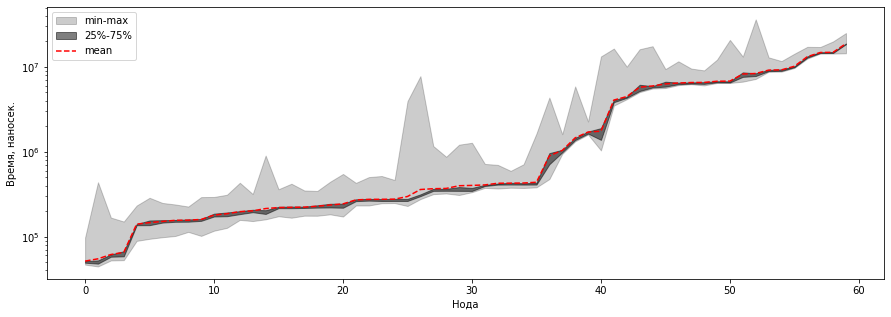

In [50]:
plt.figure(figsize=(15,5))

sorted_measurments = df.sort_values(by='mean')

x = range(len(sorted_measurments))

plt.fill_between(x, sorted_measurments['min'], sorted_measurments['max'], 
                 label='min-max', alpha=0.2, color='black')
plt.fill_between(x, sorted_measurments['25%'], sorted_measurments['75%'], 
                 label='25%-75%', alpha=0.5, color='black')

plt.plot(x, sorted_measurments['mean'], label='mean', color='red', linestyle='--')

plt.yscale('log')
plt.ylabel('Время, наносек.')
plt.xlabel('Нода')
plt.legend();